<a href="https://colab.research.google.com/github/giebm/transfer-learning/blob/main/Borres_Mier_DogBreedIdentificationCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import os
import random
from IPython.display import  Image, display

import tensorflow as tf
from keras import layers
from keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import train_test_split

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'dog-breed-identification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F7327%2F861871%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240417%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240417T084322Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D163ce61e992d9ec2b5e17a2227d2ddd74b72c103d246c1a98039c2923b288e6210ba2e722e6f233f89d34aae4ed3a3aeba771209e2cdac2bc677b51f40bdf6078336704e0c17fca7207031fb7cb7eb8c4832c039ccbabbb041676f79e93734bb0058ea26836c1af61e5b8177aebc61843dc49a6610595bf68691faae3a60002183e4d0319a24026bd84ad6270ede5b4176ed947001aab87c898b7ea51bef0ed6cf6a746a8ec115a03cf19129afac99154e96cde7338991e70c2b435e6de0536d9201469a0bdefc52cf52d42725d6ba7ccda1e2bac852982391be4f012198d79f752a8cf0f9c1def16010b92df8798dbdd1ed0c7f9e12b459f1933c3ac193480e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 724495926 bytes downloaded
Downloaded and uncompressed: dog-breed-identification
Data source import complete.


# Data Preprocessing

In [ ]:
os.listdir("/kaggle/input/dog-breed-identification/")

['train', 'labels.csv', 'test', 'sample_submission.csv']

In [ ]:
train_images_path = "/kaggle/input/dog-breed-identification/train"
test_images_path = "/kaggle/input/dog-breed-identification/test"

In [ ]:
labels_df = pd.read_csv("/kaggle/input/dog-breed-identification/labels.csv")
labels_df.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [ ]:
labels_df.describe()

id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126

In [ ]:
def is_images_same(target_dir, target_df):
    """
    That function going to check images in target_dir are equal to
    image list in target_df
    """
    len_target_dir = len(os.listdir(target_dir))
    len_target_df = len(target_df)
    if len_target_dir == len_target_df:
        print(f"Both are having same no of images:{len_target_dir}")
    else:
        print(f"Target dir having {len_target_dir} images while Target DF having {len_target_df}")

is_images_same(target_dir = train_images_path, target_df = labels_df)

Both are having same no of images:10222


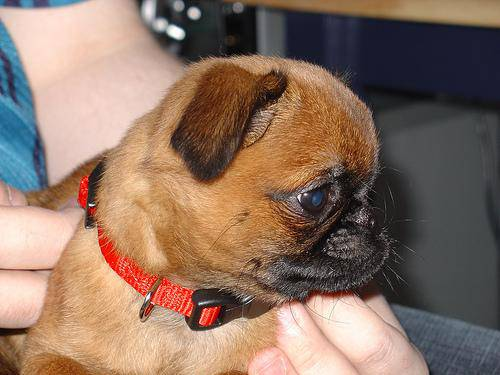

In [ ]:
from IPython.display import  Image, display
import random

example = random.choice(os.listdir(train_images_path))
example = train_images_path + "/" + example

Image(example)

In [ ]:
labels_df.columns

Index(['id', 'breed'], dtype='object')

Average Images per breed:85
Total no of breeds:120


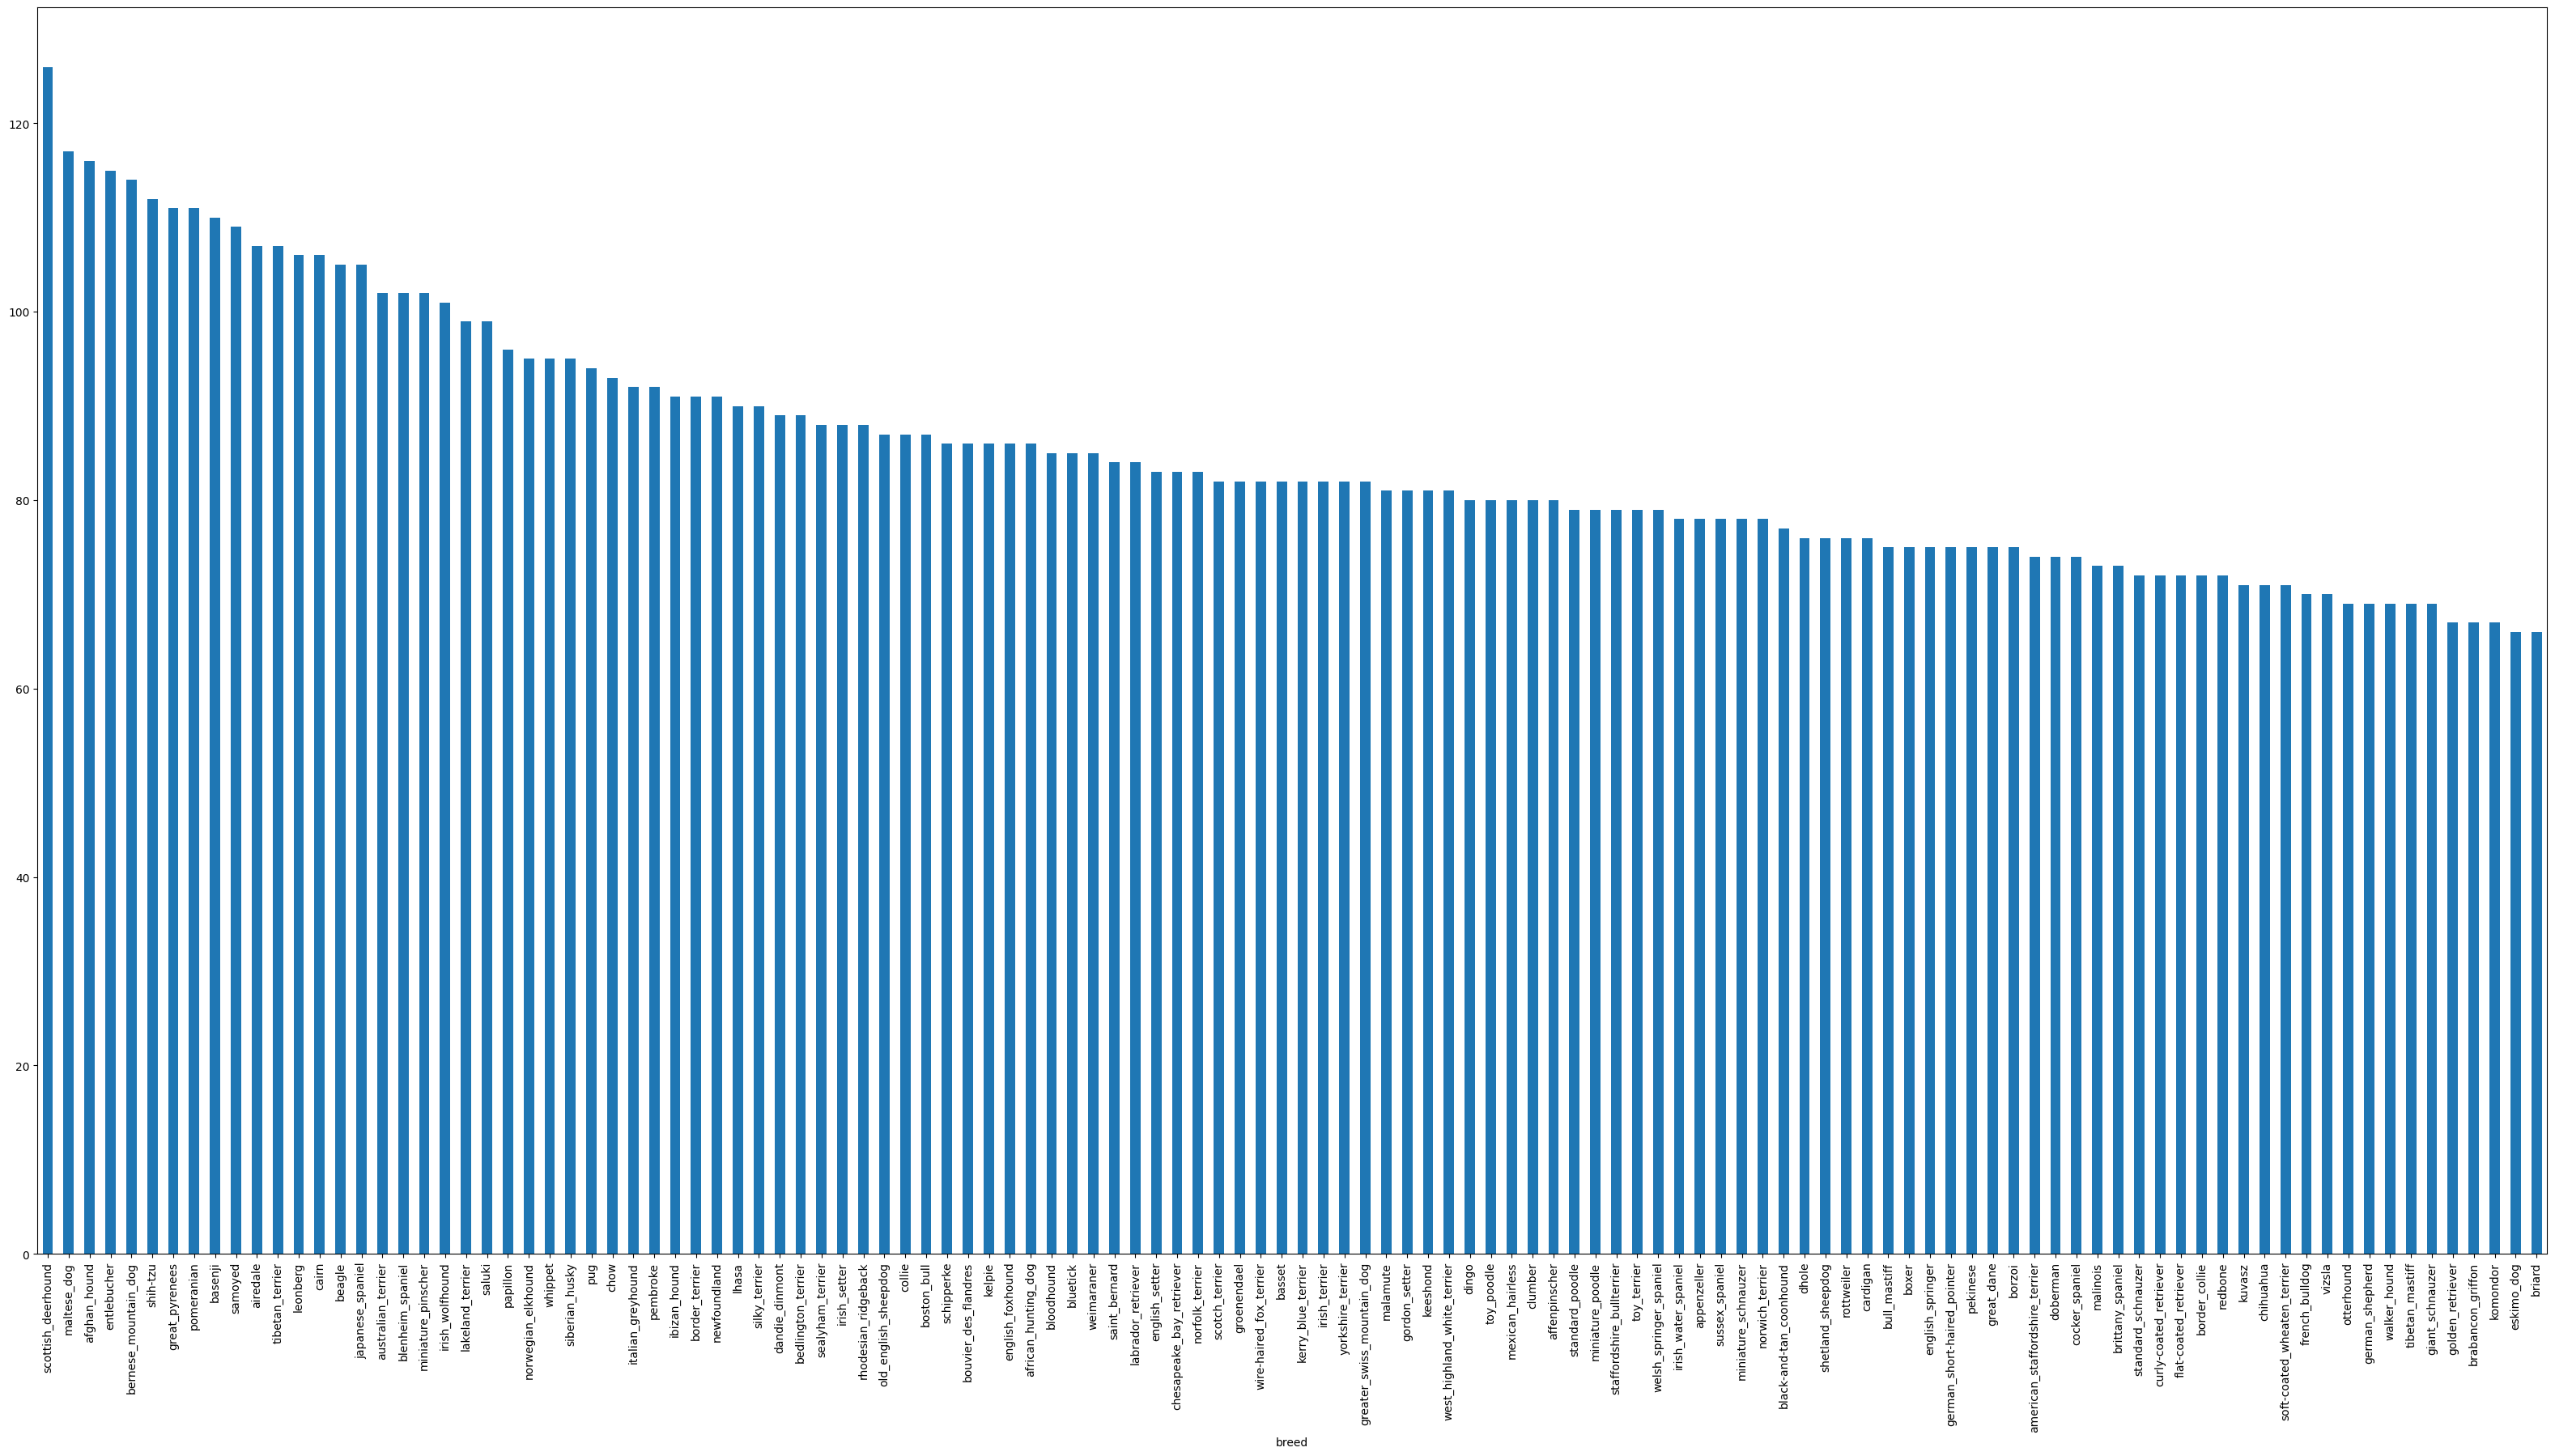

In [ ]:
labels_df["breed"].value_counts().plot.bar(figsize=(40,20))
print(f"Average Images per breed:{int(labels_df['breed'].value_counts().sum()/len(labels_df['breed'].unique()))}")
print(f"Total no of breeds:{len(labels_df['breed'].unique())}")

In [ ]:
# loading and processing the actual image data during training or evaluation of model.

fileNames = [train_images_path + "/" + fName + ".jpg" for fName in labels_df["id"]]
fileNames[:10]

['/kaggle/input/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/kaggle/input/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/kaggle/input/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/kaggle/input/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/kaggle/input/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/kaggle/input/dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/kaggle/input/dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/kaggle/input/dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/kaggle/input/dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/kaggle/input/dog-breed-identification/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [ ]:
# preparing target labels

classNames = labels_df["breed"].unique()
classNames[:5]

target_labels = [breed for breed in labels_df["breed"]]
target_labels_encoded = [label == np.array(classNames) for label in target_labels]

# Data Splitting

In [ ]:
NUM_IMAGE = 2000

X_train, X_val, Y_train, Y_val = train_test_split(fileNames[:NUM_IMAGE], target_labels_encoded[:NUM_IMAGE], test_size=0.2, random_state=42)
len(X_train), len(X_val), len(Y_train), len(Y_val)

(1600, 400, 1600, 400)

In [ ]:
X_train[0], Y_train[0]

('/kaggle/input/dog-breed-identification/train/17c5e8815cf0d086090a07b003b9b036.jpg',
 array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False

Image shape: (375, 500, 3)


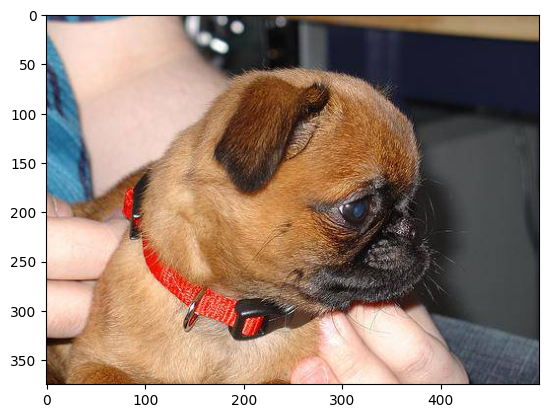

In [ ]:
img = imread(example)
plt.imshow(img)

print(f"Image shape: {img.shape}")

In [ ]:
tf.constant(img)

<tf.Tensor: shape=(375, 500, 3), dtype=uint8, numpy=
array([[[ 40, 113, 156],
        [ 44, 113, 155],
        [ 51, 109, 149],
        ...,
        [145, 119,  84],
        [145, 119,  84],
        [145, 119,  84]],

       [[ 44, 115, 159],
        [ 47, 114, 156],
        [ 51, 109, 149],
        ...,
        [148, 122,  87],
        [148, 122,  87],
        [148, 122,  87]],

       [[ 46, 115, 157],
        [ 49, 112, 153],
        [ 51, 106, 145],
        ...,
        [152, 126,  91],
        [152, 126,  91],
        [152, 126,  91]],

       ...,

       [[ 57,  24,   5],
        [ 59,  26,   7],
        [ 65,  32,  13],
        ...,
        [ 55,  57,  69],
        [ 55,  57,  69],
        [ 60,  62,  74]],

       [[ 49,  16,   0],
        [ 55,  22,   5],
        [ 62,  29,  12],
        ...,
        [ 55,  57,  69],
        [ 56,  58,  70],
        [ 61,  63,  75]],

       [[ 54,  21,   6],
        [ 61,  28,  13],
        [ 63,  30,  15],
        ...,
        [ 62,  64,  7

In [ ]:
tf.image.convert_image_dtype(img, tf.float32)

<tf.Tensor: shape=(375, 500, 3), dtype=float32, numpy=
array([[[0.15686275, 0.4431373 , 0.6117647 ],
        [0.17254902, 0.4431373 , 0.60784316],
        [0.20000002, 0.427451  , 0.58431375],
        ...,
        [0.5686275 , 0.4666667 , 0.32941177],
        [0.5686275 , 0.4666667 , 0.32941177],
        [0.5686275 , 0.4666667 , 0.32941177]],

       [[0.17254902, 0.45098042, 0.62352943],
        [0.18431373, 0.44705886, 0.6117647 ],
        [0.20000002, 0.427451  , 0.58431375],
        ...,
        [0.5803922 , 0.4784314 , 0.34117648],
        [0.5803922 , 0.4784314 , 0.34117648],
        [0.5803922 , 0.4784314 , 0.34117648]],

       [[0.18039216, 0.45098042, 0.6156863 ],
        [0.19215688, 0.43921572, 0.6       ],
        [0.20000002, 0.4156863 , 0.5686275 ],
        ...,
        [0.59607846, 0.49411768, 0.35686275],
        [0.59607846, 0.49411768, 0.35686275],
        [0.59607846, 0.49411768, 0.35686275]],

       ...,

       [[0.22352943, 0.09411766, 0.01960784],
        [0.23

In [ ]:
# ensures that your images are loaded, decoded, normalized, and resized to the appropriate dimensions before being fed into your model for training or evaluation.

IMAGE_SIZE = 224

def process_image(image_path):
    img = tf.io.read_file(image_path)
    # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
    img = tf.io.decode_image(img, channels =3)
    # Convert the colour channel values from 0-225 values to 0-1 values
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize the image to our desired size (224, 244)
    img = tf.image.resize_with_crop_or_pad(img, 224, 224)
    return img

In [ ]:
def get_image_label(image_path, label):
    image = process_image(image_path)
    return image, label

get_image_label(X_train[10], Y_train[10])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.37254903, 0.5764706 , 0.19215688],
         [0.36862746, 0.56078434, 0.20392159],
         [0.3372549 , 0.50980395, 0.20000002],
         ...,
         [1.        , 0.92549026, 0.3647059 ],
         [0.9843138 , 0.909804  , 0.36862746],
         [1.        , 0.9450981 , 0.43921572]],
 
        [[0.34901962, 0.52156866, 0.14117648],
         [0.3254902 , 0.49411768, 0.13333334],
         [0.37647063, 0.5411765 , 0.21176472],
         ...,
         [0.69411767, 0.6745098 , 0.18039216],
         [0.7803922 , 0.7568628 , 0.28627452],
         [0.7411765 , 0.7254902 , 0.29411766]],
 
        [[0.30980393, 0.4666667 , 0.09019608],
         [0.34509805, 0.5058824 , 0.13725491],
         [0.4156863 , 0.5803922 , 0.24313727],
         ...,
         [0.40784317, 0.43137258, 0.01568628],
         [0.5372549 , 0.5568628 , 0.16470589],
         [0.38431376, 0.41176474, 0.04705883]],
 
        ...,
 
        [[0.56078434, 0.7607844 

In [ ]:
#  create batches of data suitable for training, validation, or testing your model. It ensures that the data is shuffled (for training) and preprocessed before being fed into the model.

BATCH_SIZE = 32

def create_data_batches(X, y=None, batch_size = BATCH_SIZE, valid_data= False, test_data=False):
    if test_data:
        test_data = tf.data.Dataset.from_tensor_slices(tf.constant(X))
        test_data = test_data.map(process_image).batch(BATCH_SIZE)
        return test_data

    if valid_data:
        valid_data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
        valid_data = valid_data.map(get_image_label).batch(BATCH_SIZE)
        return valid_data

    #shuffle and create training data
    else:
        train_data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y))).shuffle(buffer_size = len(X))
        train_data = train_data.map(get_image_label).batch(BATCH_SIZE)
        return train_data

In [ ]:
train_data = create_data_batches(X_train, Y_train)
valid_data = create_data_batches(X_val, Y_val, valid_data=True)

In [ ]:
sample = next(iter(train_data))
sample[0][0]

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.11764707, 0.14117648, 0.18823531],
        [0.11764707, 0.14117648, 0.18823531],
        [0.10980393, 0.13333334, 0.18039216],
        ...,
        [0.41176474, 0.40784317, 0.38823533],
        [0.9333334 , 0.9294118 , 0.909804  ],
        [0.8000001 , 0.7960785 , 0.77647066]],

       [[0.11764707, 0.14117648, 0.18823531],
        [0.11764707, 0.14117648, 0.18823531],
        [0.1137255 , 0.13725491, 0.18431373],
        ...,
        [0.54509807, 0.5411765 , 0.52156866],
        [0.9568628 , 0.95294124, 0.9333334 ],
        [0.75294125, 0.7490196 , 0.7294118 ]],

       [[0.11764707, 0.14117648, 0.18823531],
        [0.11764707, 0.14117648, 0.18823531],
        [0.1137255 , 0.13725491, 0.18431373],
        ...,
        [0.58431375, 0.5803922 , 0.56078434],
        [0.8941177 , 0.89019614, 0.8705883 ],
        [0.74509805, 0.7411765 , 0.72156864]],

       ...,

       [[0.07450981, 0.09019608, 0.08627451],
        [0.05

In [ ]:
def show_images(images, label):
    plt.figure(figsize = (12,12))

    for i in range(0,16):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i])
        plt.title(classNames[tf.argmax(label[i])])
        plt.axis("off")

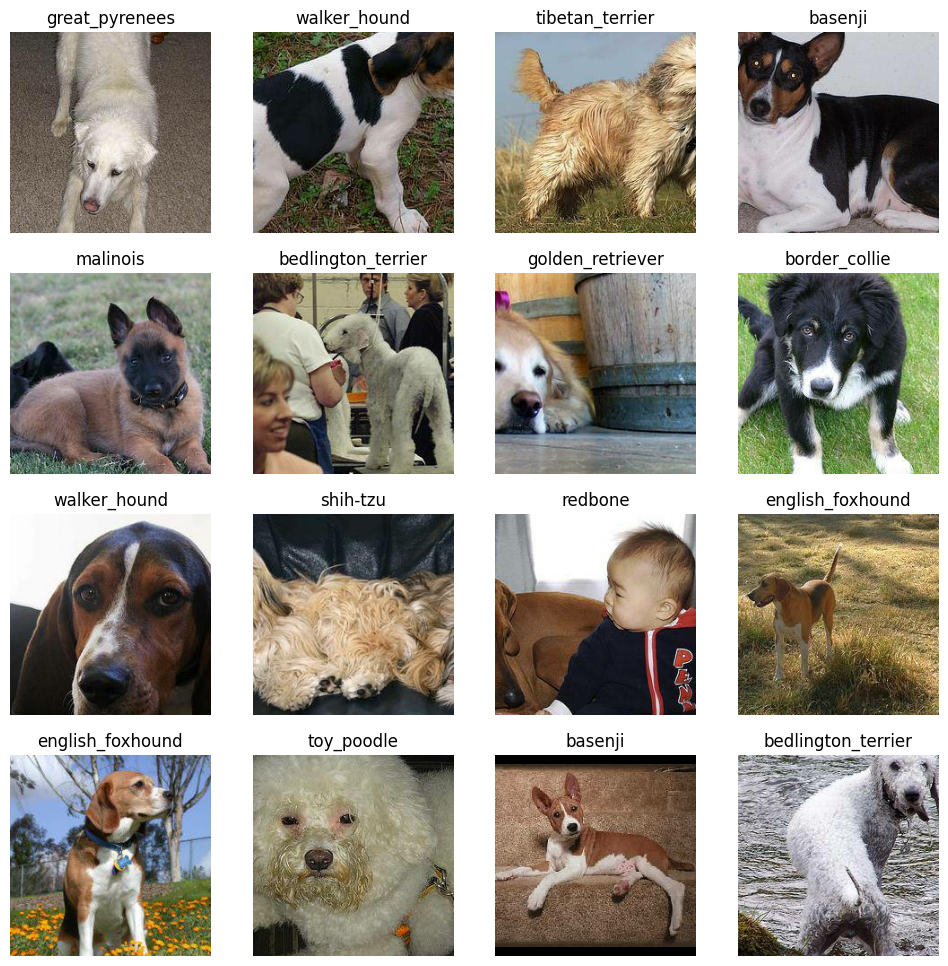

In [ ]:
train_images, train_labels = next(train_data.as_numpy_iterator())
show_images(train_images, train_labels)

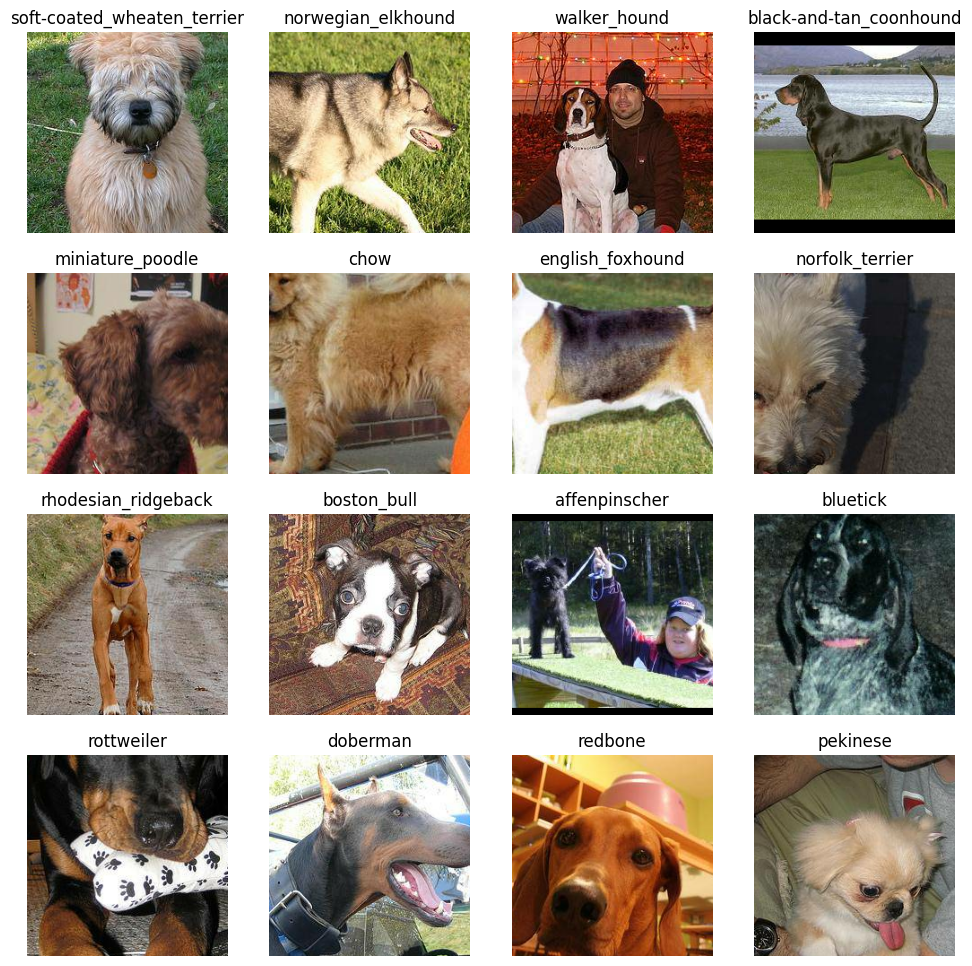

In [ ]:
val_images, val_labels = next(valid_data.as_numpy_iterator())
show_images(val_images, val_labels)

# Model Architecture / Creation

In [ ]:
from keras import layers

def create_model():
    base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top = False,
                                                     classes = len(classNames))
    base_model.trainable = False

    inputs = layers.Input(shape = (224,224,3))
    x = base_model(inputs, training = False)
    x = tf.keras.layers.GlobalAveragePooling2D(name= "global_average_pooling")(x)
    x = layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(len(classNames), activation="softmax")(x)


    ModelDogBreed = tf.keras.Model(inputs, outputs)

    ModelDogBreed.compile(loss = "categorical_crossentropy",
                         optimizer = tf.keras.optimizers.Adam(),
                         metrics=["accuracy"])

    return ModelDogBreed

In [ ]:
model = create_model()

EarlyStoppingCallbacks = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=2, baseline=None, restore_best_weights=True
)

# Fucking Model Training

In [ ]:
ModelDogBreed_History = model.fit(train_data,
                                         steps_per_epoch = len(train_data),
                                         epochs = 10,
                                         validation_data= valid_data,
                                         validation_steps = len(valid_data),
                                         callbacks = [EarlyStoppingCallbacks])

Epoch 1/10
50/50 [==============================] - 85s 2s/step - loss: 4.1239 - accuracy: 0.1294 - val_loss: 2.7266 - val_accuracy: 0.3850
Epoch 2/10
50/50 [==============================] - 80s 2s/step - loss: 1.7800 - accuracy: 0.6019 - val_loss: 1.9469 - val_accuracy: 0.5325
Epoch 3/10
50/50 [==============================] - 72s 1s/step - loss: 0.9640 - accuracy: 0.8244 - val_loss: 1.7177 - val_accuracy: 0.5550
Epoch 4/10
50/50 [==============================] - 101s 2s/step - loss: 0.5999 - accuracy: 0.9112 - val_loss: 1.6030 - val_accuracy: 0.6000
Epoch 5/10
50/50 [==============================] - 90s 2s/step - loss: 0.4315 - accuracy: 0.9463 - val_loss: 1.5142 - val_accuracy: 0.6175
Epoch 6/10
50/50 [==============================] - 77s 2s/step - loss: 0.3063 - accuracy: 0.9750 - val_loss: 1.4794 - val_accuracy: 0.6200
Epoch 7/10
50/50 [==============================] - 79s 2s/step - loss: 0.2301 - accuracy: 0.9869 - val_loss: 1.4772 - val_accuracy: 0.6200
Epoch 8/10
50/50 [=

# Model Eval

In [ ]:
model.evaluate(valid_data)

13/13 [==============================] - 15s 1s/step - loss: 1.4253 - accuracy: 0.6375


[1.425260066986084, 0.637499988079071]

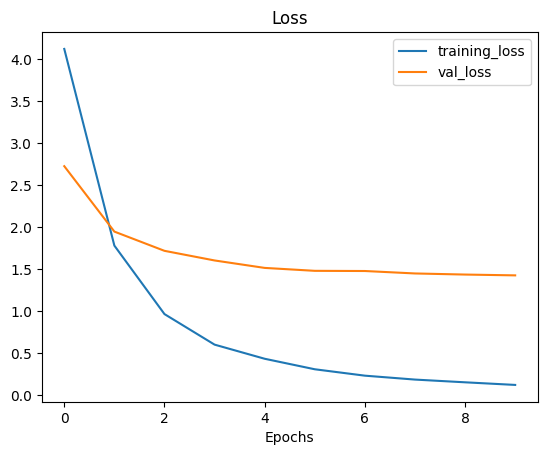

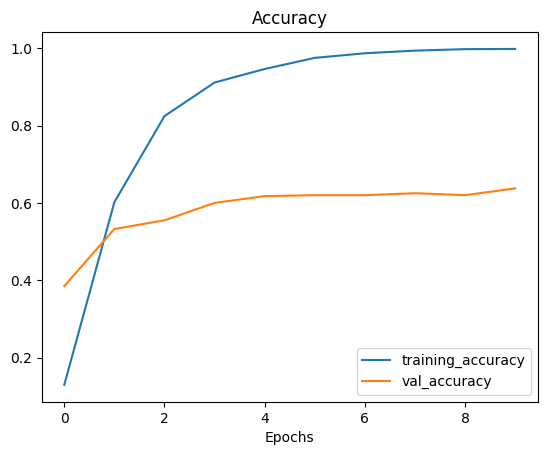

In [ ]:
history = ModelDogBreed_History

loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(history.history['loss']))

plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.figure()
plt.plot(epochs, accuracy, label='training_accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()

In [ ]:
predictions = model.predict(valid_data)
predictions

13/13 [==============================] - 15s 1s/step


array([[1.33999289e-04, 2.13819454e-04, 4.10491448e-05, ...,
        4.81051575e-06, 3.40822844e-05, 1.03347975e-05],
       [2.59386376e-04, 2.05999031e-03, 2.17635284e-06, ...,
        7.82289862e-06, 4.22345056e-06, 3.02973553e-04],
       [4.14204225e-03, 2.69452380e-06, 2.79159138e-07, ...,
        2.43475457e-04, 4.52780951e-05, 5.15964290e-04],
       ...,
       [6.79705227e-06, 5.70443735e-05, 3.03562786e-07, ...,
        2.36147571e-06, 1.78344009e-04, 4.55282308e-04],
       [2.66899224e-05, 3.82000944e-05, 2.54780025e-05, ...,
        4.93339485e-07, 1.44395017e-06, 1.42123235e-05],
       [3.49396796e-05, 2.01070932e-07, 2.15223849e-07, ...,
        7.51033099e-07, 9.39392351e-07, 1.53959650e-06]], dtype=float32)

In [ ]:
def get_pred_label(prediction_probabilities):
    """
    Turns an array of prediction probabilities into a label.
    """
    return classNames[np.argmax(prediction_probabilities)]

pred_label = get_pred_label(predictions[0])
print(pred_label)

soft-coated_wheaten_terrier


In [ ]:
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []

  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(classNames[np.argmax(label)])
  return images, labels

val_images, val_labels = unbatchify(valid_data)
val_images[0], val_labels[0]

(array([[[0.48235297, 0.56078434, 0.3137255 ],
         [0.3803922 , 0.4666667 , 0.21568629],
         [0.33333334, 0.43137258, 0.1764706 ],
         ...,
         [0.32941177, 0.48627454, 0.2784314 ],
         [0.30588236, 0.454902  , 0.25490198],
         [0.32156864, 0.44705886, 0.2627451 ]],
 
        [[0.43529415, 0.5176471 , 0.25490198],
         [0.47450984, 0.56078434, 0.30588236],
         [0.2901961 , 0.3921569 , 0.13725491],
         ...,
         [0.3529412 , 0.48627454, 0.28627452],
         [0.31764707, 0.4431373 , 0.2509804 ],
         [0.30588236, 0.41176474, 0.23529413]],
 
        [[0.2509804 , 0.33333334, 0.0627451 ],
         [0.5254902 , 0.6156863 , 0.34901962],
         [0.38823533, 0.48627454, 0.227451  ],
         ...,
         [0.29803923, 0.40784317, 0.21568629],
         [0.27450982, 0.37647063, 0.19215688],
         [0.2784314 , 0.3803922 , 0.20392159]],
 
        ...,
 
        [[0.21176472, 0.33333334, 0.20784315],
         [0.24705884, 0.36862746, 0.24705

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth label and image for sample n.
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
  pred_label = get_pred_label(pred_prob)

  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("{} {:2.0f}% ({})".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)

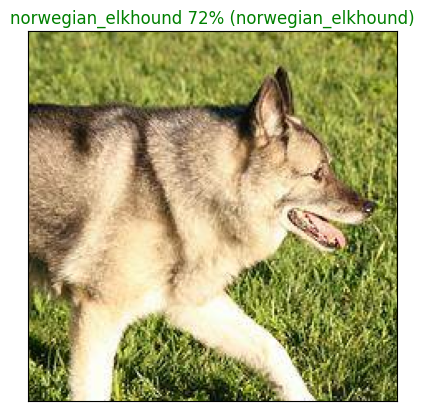

In [ ]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images)

In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plots the top 10 highest prediction confidences along with
  the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]
  pred_label = get_pred_label(pred_prob)

  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  top_10_pred_labels = classNames[top_10_pred_indexes]

  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

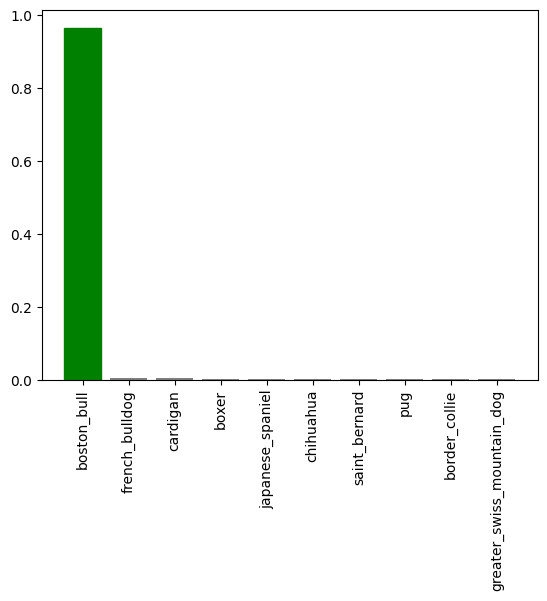

In [ ]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

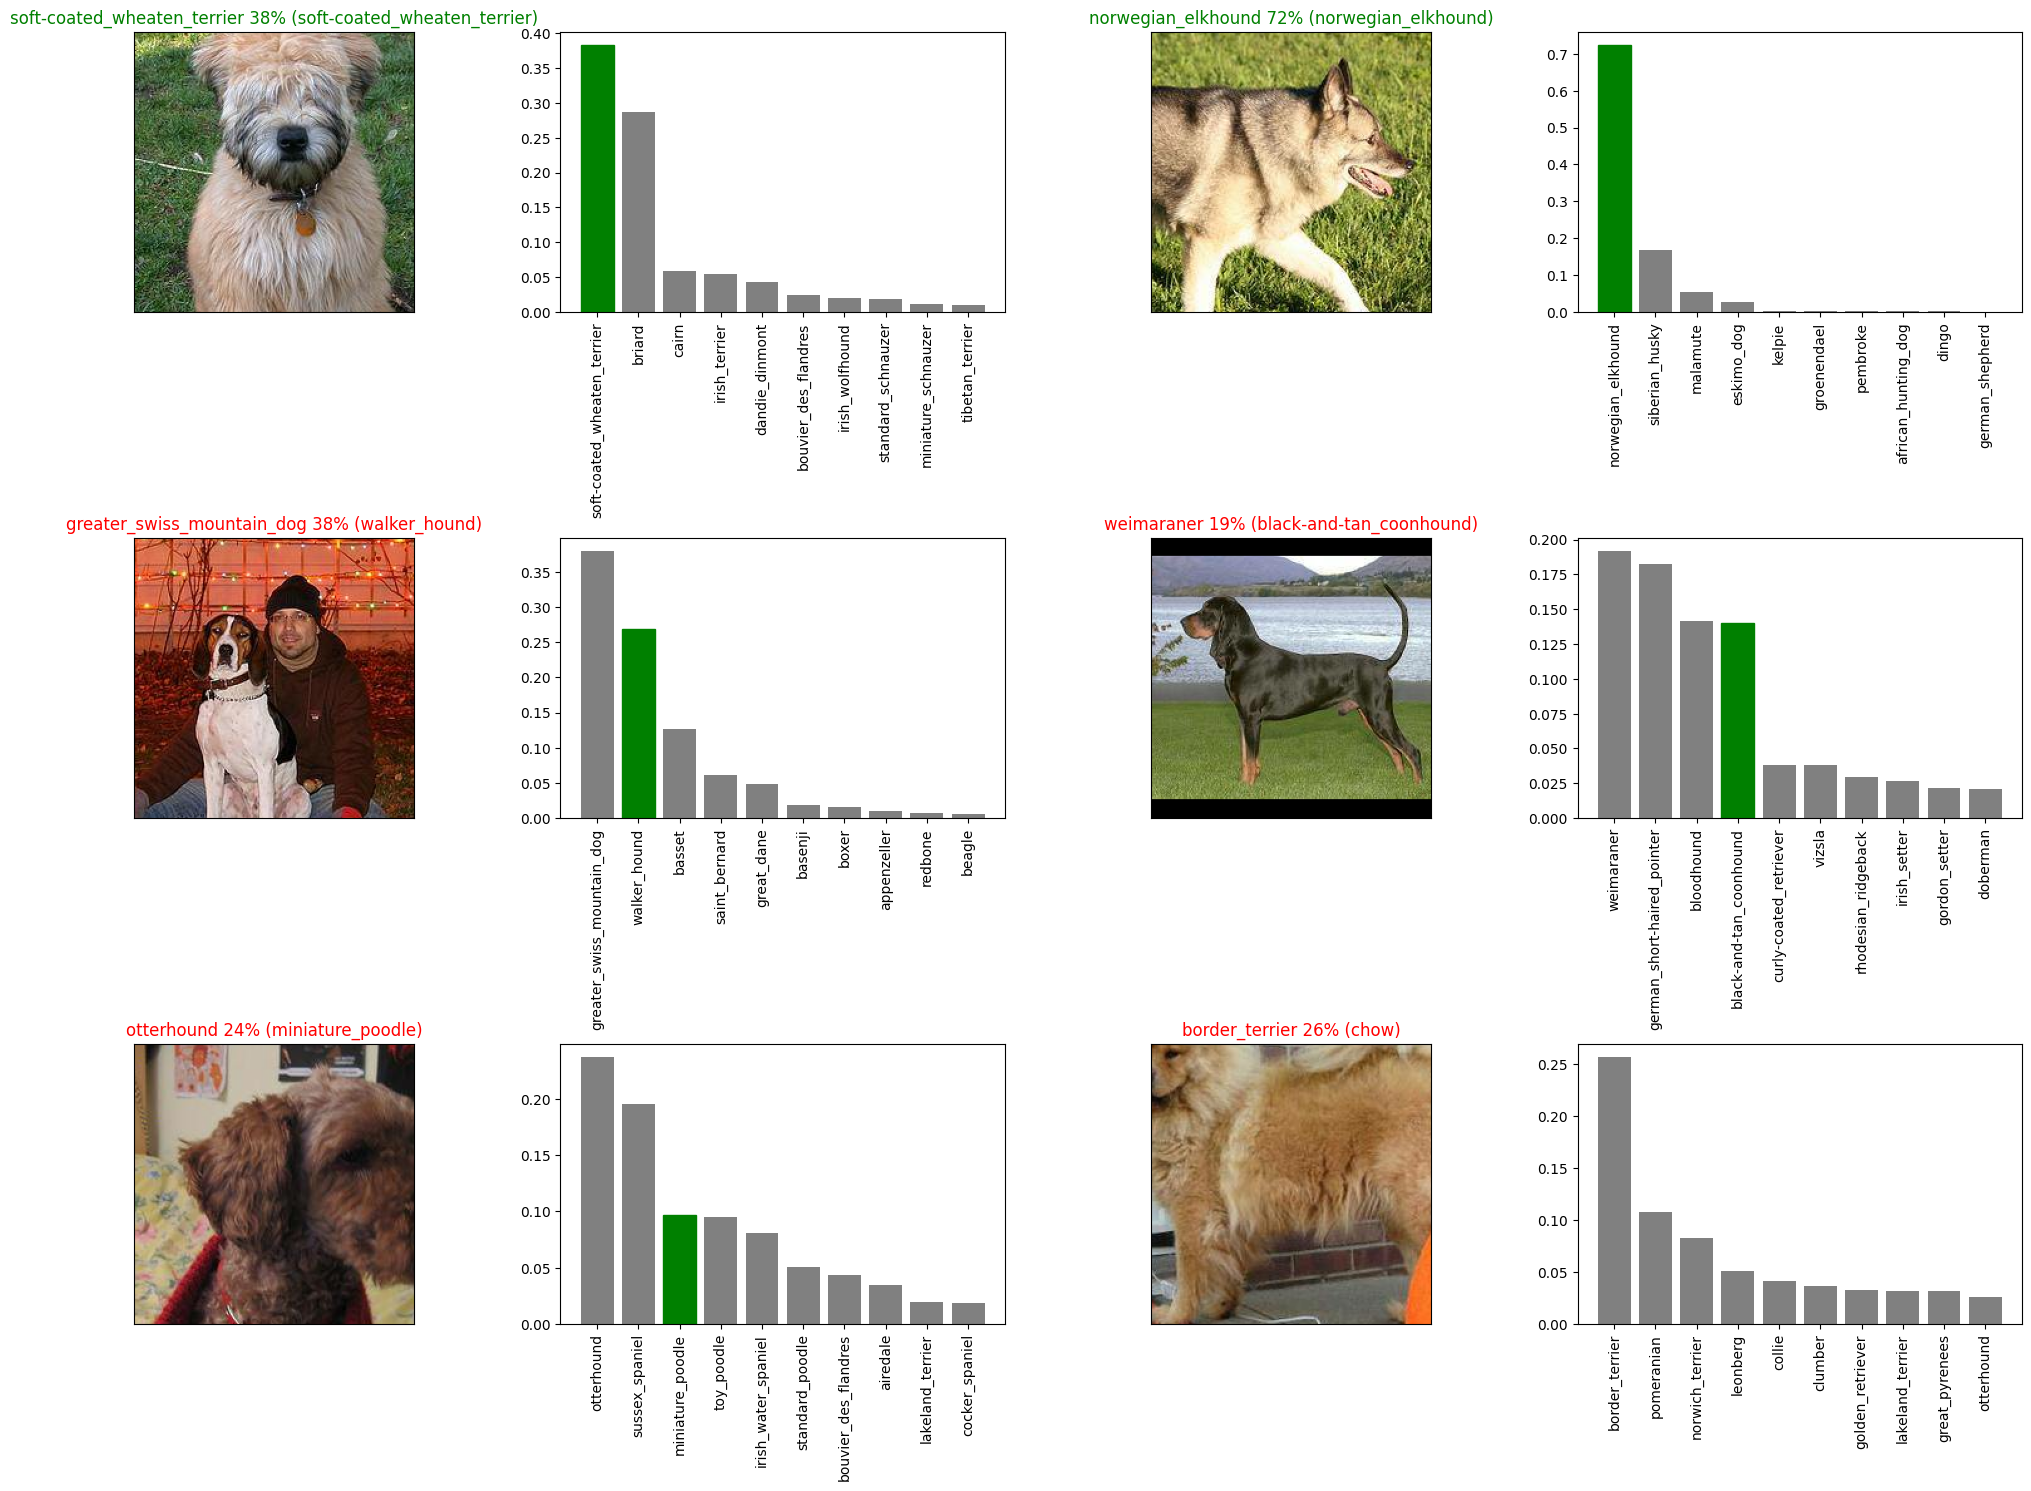

In [ ]:
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(predictions, true_labels):
    pred_labels = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=1)
    recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=1)
    f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=1)
    return accuracy, precision, recall, f1

# Evaluate the model
predictions = model.predict(valid_data)
true_labels = np.argmax(Y_val, axis=1)  # Assuming Y_val is the true labels
accuracy, precision, recall, f1 = evaluate_model(predictions, true_labels)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

13/13 [==============================] - 16s 1s/step
Accuracy: 0.6375
Precision: 0.7289375
Recall: 0.6375
F1 Score: 0.6417844363239101


In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
# Freeze the base model layers
base_model.trainable = False

In [ ]:

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(classNames), activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(fileNames[:NUM_IMAGE],
                                                  target_labels_encoded[:NUM_IMAGE],
                                                  test_size=0.2,
                                                  random_state=42)

In [ ]:
train_data = create_data_batches(X_train, Y_train)
valid_data = create_data_batches(X_val, Y_val, valid_data=True)

In [ ]:
history = model.fit(train_data,
                    epochs=10,
                    validation_data=valid_data,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)])


Epoch 1/10
50/50 [==============================] - 84s 2s/step - loss: 4.1782 - accuracy: 0.1344 - val_loss: 2.7525 - val_accuracy: 0.3975
Epoch 2/10
50/50 [==============================] - 80s 2s/step - loss: 1.7606 - accuracy: 0.6194 - val_loss: 1.9044 - val_accuracy: 0.5375
Epoch 3/10
50/50 [==============================] - 83s 2s/step - loss: 0.9639 - accuracy: 0.8206 - val_loss: 1.6960 - val_accuracy: 0.5550
Epoch 4/10
50/50 [==============================] - 80s 2s/step - loss: 0.6166 - accuracy: 0.8994 - val_loss: 1.5565 - val_accuracy: 0.5925
Epoch 5/10
50/50 [==============================] - 80s 2s/step - loss: 0.4153 - accuracy: 0.9519 - val_loss: 1.5215 - val_accuracy: 0.5800
Epoch 6/10
50/50 [==============================] - 74s 1s/step - loss: 0.3004 - accuracy: 0.9756 - val_loss: 1.4820 - val_accuracy: 0.6100
Epoch 7/10
50/50 [==============================] - 80s 2s/step - loss: 0.2329 - accuracy: 0.9856 - val_loss: 1.4848 - val_accuracy: 0.6075
Epoch 8/10
50/50 [==

In [ ]:
# Evaluate the model on validation data
model.evaluate(valid_data)

13/13 [==============================] - 15s 1s/step - loss: 1.4340 - accuracy: 0.6175


[1.4339818954467773, 0.6175000071525574]

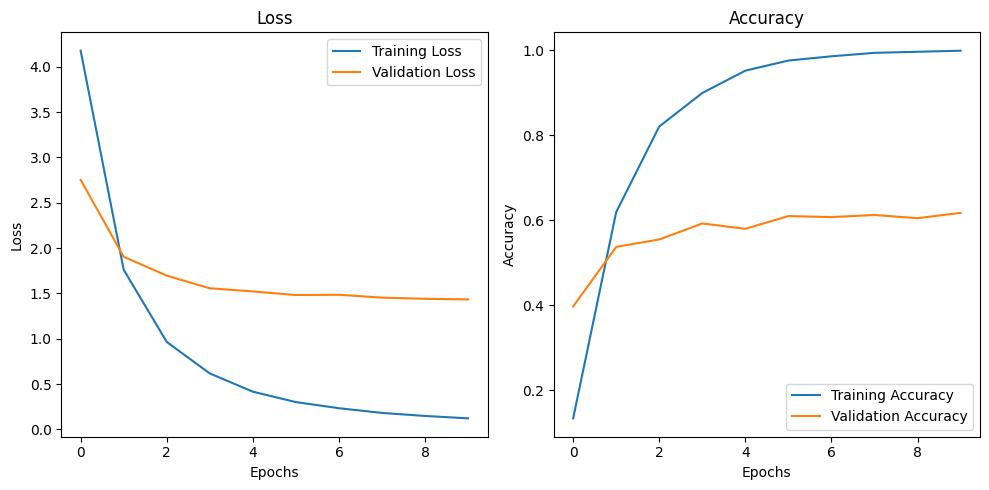

In [ ]:
# Plot training and validation metrics
# Plotting Loss
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()  # Adjusts spacing between subplots for better readability
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(predictions, true_labels):
    pred_labels = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=1)
    recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=1)
    f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=1)
    return accuracy, precision, recall, f1

# Evaluate the model
predictions = model.predict(valid_data)
true_labels = np.argmax(Y_val, axis=1)  # Assuming Y_val is the true labels
accuracy, precision, recall, f1 = evaluate_model(predictions, true_labels)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")